In [1]:
%pylab inline
import torch
import torch.nn as nn
from tqdm import tqdm_notebook as tqdm
from torch.utils.data import TensorDataset, DataLoader
from asap.model import VAE
from asap.data import load_dataset
from sklearn.linear_model import LinearRegression

Populating the interactive namespace from numpy and matplotlib


/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/lm715/anaconda2/envs/dlenv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


### Checking the loss curve to evaluate the right epoch to choose

We evaluate the loss of the autoencoder and find that overfitting occurs from ~epoch 20.  
We choose epoch 20 as our model for the data.  

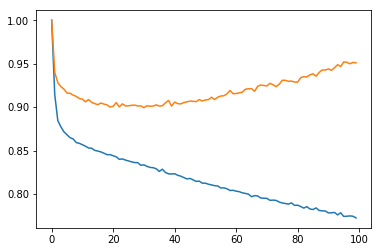

In [2]:
losses = np.load("../runs/asap_1/output/losses.npy")
plt.plot(losses[:, 0]/losses[:, 0].max())
plt.plot(losses[:, 1]/losses[:, 1].max())

### Loading the pre-trained model
We can perform the following computations on CPU, the models are small.  
Also we set the model to .eval() mode so that it doesn't compute any gradients or updates parameters.  

In [3]:
model = VAE()
model.load_state_dict(torch.load("../runs/asap_1/output/model_epoch_20.pth", map_location='cpu'))
model.eval()

VAE(
  (conv1): Conv1d(2, 3, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv2): Conv1d(3, 32, kernel_size=(2,), stride=(2,))
  (conv3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (conv4): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (fc1): Linear(in_features=1024, out_features=128, bias=True)
  (fc21): Linear(in_features=128, out_features=2, bias=True)
  (fc22): Linear(in_features=128, out_features=2, bias=True)
  (fc3): Linear(in_features=2, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=1024, bias=True)
  (deconv1): ConvTranspose1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv2): ConvTranspose1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (deconv3): ConvTranspose1d(32, 32, kernel_size=(2,), stride=(2,))
  (conv5): Conv1d(32, 2, kernel_size=(3,), stride=(1,), padding=(1,))
  (relu): ReLU()
  (sigmoid): Sigmoid()
)

### Example forward pass through the network

Here I show an example of a forward pass of some random noise as input x and the reconstruct x_.  
we can also simply decode from latent space by using the .decode method of the VAE.  

torch.Size([128, 2, 64])
torch.Size([128, 2, 64])


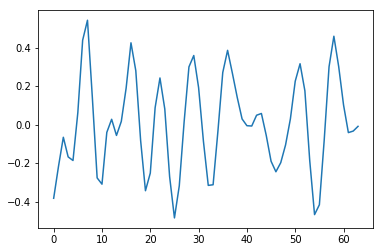

In [4]:
with torch.set_grad_enabled(False):
    x = torch.randn(128, 2, 64)
    x_, mu, logvar, z = model(x)   
    print(x_.size())
    x_ = model.decode(z)
    print(x_.size())
    
plt.plot(x_[0, 0].numpy())

### Loading the dataset of all the traces flattened on top heimdahl

In [5]:
_, _, _, _, X_all, y_all = load_dataset("../dataset/glitne/flattened/near_64_samples.npy", "../dataset/glitne/flattened/far_64_samples.npy", 64)

### We forward pass the traces and store reconstructions and latent variables

In [6]:
dset = TensorDataset(X_all, y_all)
loader = DataLoader(dset, batch_size=1024, shuffle=False)
latents, recons = [], []
for trace, _ in tqdm(loader):
    with torch.set_grad_enabled(False):
        x_, mu, logvar, z = model(trace) 
        latents.append(z)
        recons.append(x_)

In [7]:
all_sampled = torch.cat(recons).numpy()
all_latents = torch.cat(latents).numpy()

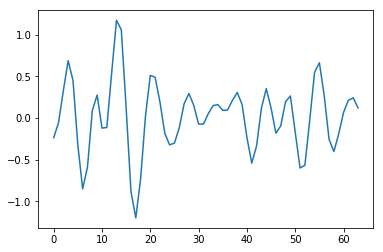

In [8]:
plt.plot(all_sampled[0, 1])

### We load the original data flattened on heimdahl to make comparison plots

In [9]:
near_traces = np.load("../dataset/glitne/flattened/near_64_samples.npy")
far_traces = np.load("../dataset/glitne/flattened/far_64_samples.npy")
print(near_traces.shape)

(101, 251, 64)


### Top down view of the mean amplitude of near and far offset for original data and reconstructed  data

There seems to be a signal in both the reconstruct near and far offset with slightly different responses.  
Can't see anything in the far offset of the original data.

Text(0.5,1,'Far Offset')

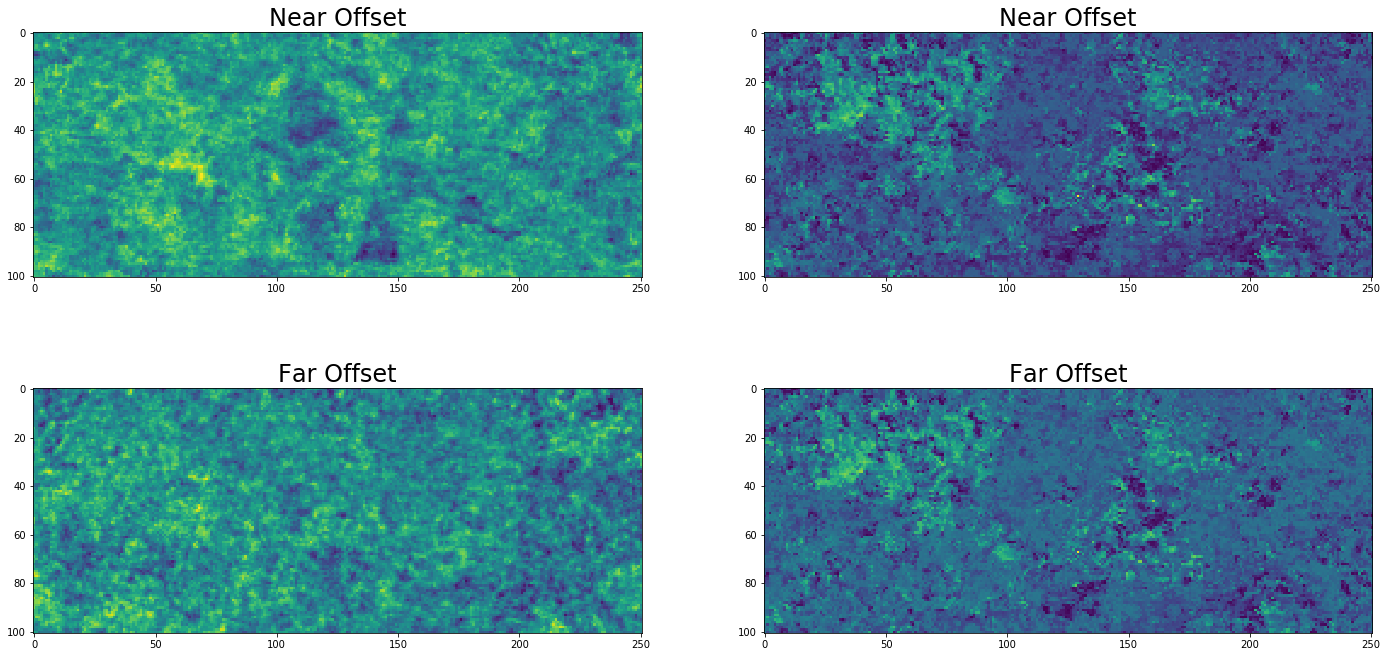

In [10]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12))
near_sampled = all_sampled.reshape(101, 251, 2, 64)[:, :, 0, :]
far_sampled = all_sampled.reshape(101, 251, 2, 64)[:, :, 1, :]
vmin = near_traces.min()
vmax = near_traces.max()

ax[0, 1].imshow(np.mean(near_sampled, 2))
sc = ax[1, 1].imshow(np.mean(far_sampled, 2))
ax[0, 1].set_title("Near Offset", fontsize=24)
ax[1, 1].set_title("Far Offset", fontsize=24)

ax[0, 0].imshow(np.mean(near_traces, 2))
sc = ax[1, 0].imshow(np.mean(far_traces, 2))
ax[0, 0].set_title("Near Offset", fontsize=24)
ax[1, 0].set_title("Far Offset", fontsize=24)

### Cross-section view of the data going through the well inline

Text(0,0.5,'Far Offset')

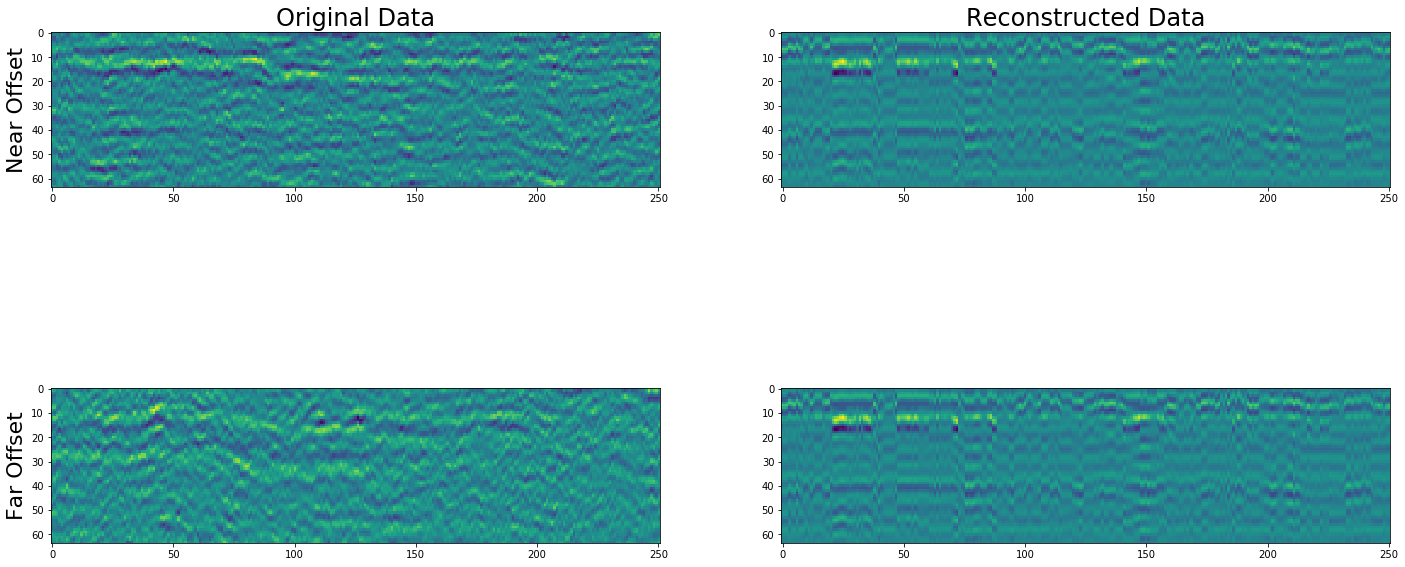

In [11]:
fig, ax = plt.subplots(2, 2, figsize=(24, 12))

ax[0, 1].imshow(near_sampled[38, :].T)
sc = ax[1, 1].imshow(far_sampled[38, :].T)
ax[0, 0].set_title("Original Data", fontsize=24)
ax[0, 1].set_title("Reconstructed Data", fontsize=24)

ax[0, 0].imshow(near_traces[38].T)
sc = ax[1, 0].imshow(far_traces[38].T)
ax[0, 0].set_ylabel("Near Offset", fontsize=22)
ax[1, 0].set_ylabel("Far Offset", fontsize=22)
#fig.savefig("comparison_real_and_reconstructed_line.png", dpi=300, bbox_inches="tight")

### We perform a Fluid Factor analysis on the reconstructed near and far offset data

In [12]:
x_avo = near_sampled.reshape(-1, 1)
y_avo = far_sampled.reshape(-1, 1)-x_avo

lin_reg = LinearRegression(fit_intercept=False, normalize=False, copy_X=True, n_jobs=1)
lin_reg.fit(x_avo, y_avo)
print(lin_reg.coef_)

[[-0.00112896]]


In [13]:
FF = y_avo-lin_reg.coef_*x_avo
FF = FF.reshape(*near_sampled.shape)
print(lin_reg.coef_)
RF = lin_reg.coef_*y_avo+x_avo
RF = RF.reshape(*near_sampled.shape)

x_avo_d = near_traces.reshape(-1, 1)
y_avo_d = far_traces.reshape(-1, 1)-x_avo_d

#0.89 was the coefficient of the original data
FF_d = y_avo_d+0.89*x_avo_d
FF_d = FF_d.reshape(*near_traces.shape)
RF_d = -0.89*y_avo_d+x_avo_d
RF_d = RF_d.reshape(*near_traces.shape)

[[-0.00112896]]


### Plotting the fluid factor spatially and comparing to original data fluid factor

Text(0.5,1,'Reconstructed Data')

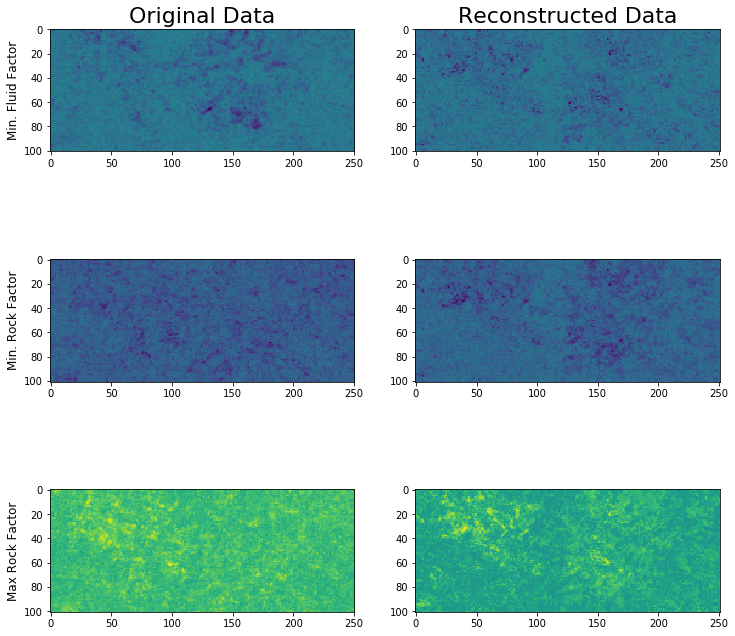

In [14]:
fig, ax = plt.subplots(3, 2, figsize=(12, 12))

ax[0, 0].imshow(np.min(FF_d, 2), vmin=FF_d.min(), vmax=FF_d.max())
ax[1, 0].imshow(np.min(RF_d, 2), vmin=RF_d.min(), vmax=RF_d.max())
ax[2, 0].imshow(np.max(RF_d, 2), vmin=RF_d.min(), vmax=RF_d.max())

ax[0, 1].imshow(np.min(FF, 2), vmin=FF.min(), vmax=FF.max())
ax[1, 1].imshow(np.min(RF, 2), vmin=RF.min(), vmax=RF.max())
ax[2, 1].imshow(np.max(RF, 2), vmin=RF.min(), vmax=RF.max())

ax[0, 0].set_ylabel("Min. Fluid Factor", fontsize=12)
ax[1, 0].set_ylabel("Min. Rock Factor", fontsize=12)
ax[2, 0].set_ylabel("Max Rock Factor", fontsize=12)

ax[0, 0].set_title("Original Data", fontsize=22)
ax[0, 1].set_title("Reconstructed Data", fontsize=22)
#fig.savefig("comparison_near_far.png", dpi=300, bbox_inches="tight")

### Extracting some traces around the well

In [15]:
### some stupid way of getting the local linear indices from an x, y gridded data object.
### extracting the trace ids around the well
counts = []
count = 0
for i in range(near_traces.shape[0]):
    for j in range(near_traces.shape[1]):
        if i in [37, 38, 39] and j in [137, 138, 139]:
            counts.append(count)
        count += 1
print(counts)   

[9424, 9425, 9426, 9675, 9676, 9677, 9926, 9927, 9928]


### Spatial plot of the latent variables

Here we show the latent variables in a spatial layout (top-down view).  
The latent-variables are a _per trace_ property therefore we get a 2D view of the latent space mapped back to our top down reservoir view.

We show here the:
- 1st component
- 2nd component
- And the distance from the origin as the radius.

It seems the radius has a nice highlighting of the rock and fluid factor responses.  
This metric (radius) is motivated by the fact that the VAE assumes a Gaussian prior, therefore samples that do not follow the distribution or are outliers will be further from the center of the Gaussian density.  

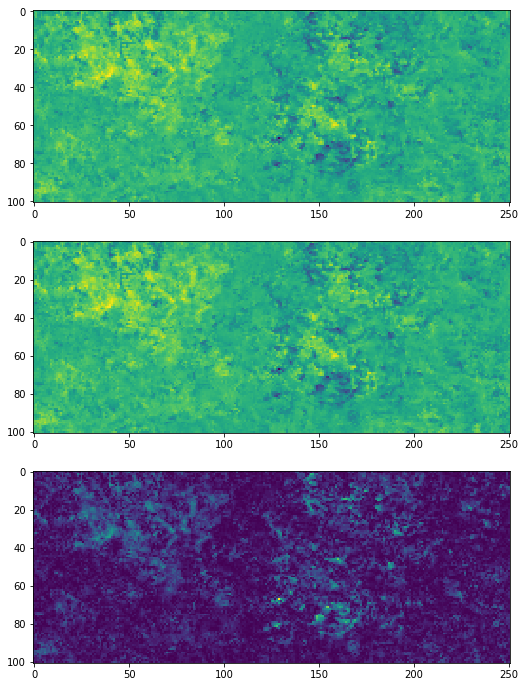

In [16]:
fig, ax = plt.subplots(3, 1, figsize=(12, 12))
r = np.sqrt(all_latents[:, 0]**2+all_latents[:, 0]**2)
ax[0].imshow(all_latents[:, 0].reshape(101, 251))
ax[1].imshow(all_latents[:, 0].reshape(101, 251))
ax[2].imshow(r.reshape(101, 251))

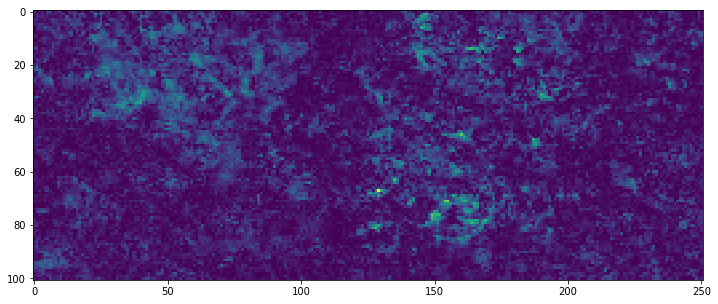

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
ax.imshow(r.reshape(101, 251))

### Just the latent variables and the fluid factor mapped together

The red dots here are the traces around the well. The red dot at the origin is actually the well trace.
It's possible that it may be better not to normalize the whole process against this well if we know it is an outlier.

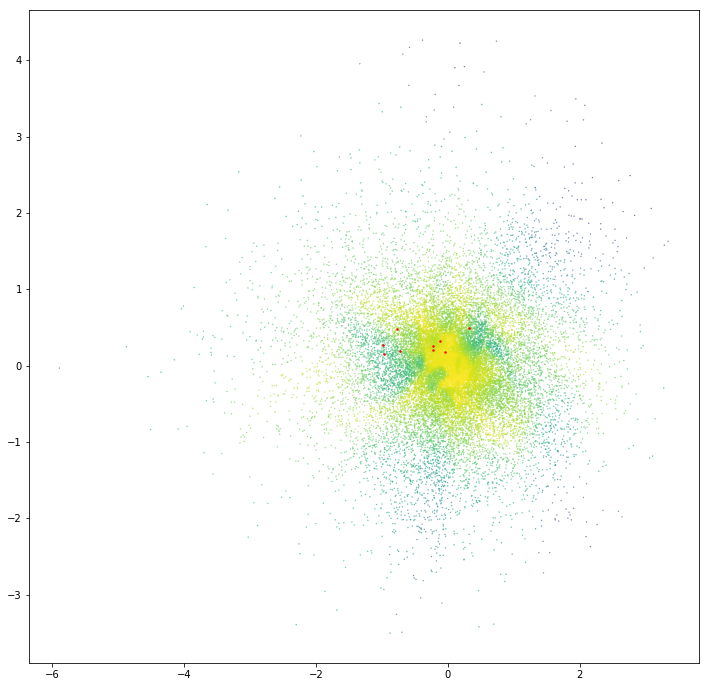

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
sc = ax.scatter(all_latents[:, 0], all_latents[:, 1], s=0.1, c=np.min(FF, 2).reshape(-1))
for i, latent in enumerate(all_latents):
    if i in counts:
        ax.scatter(latent[0], latent[1], c="red", s=2)
#fig.savefig("unsupervised_encoder_space.png", dpi=300, bbox_inches="tight")

### Loading the horizon and plotting the indicators together with contour maps

In [19]:
horizon = np.load("../dataset/glitne/horizon/horizon.npy")
X, Y = np.meshgrid(np.arange(0, horizon.shape[1]), np.arange(0, horizon.shape[0]))

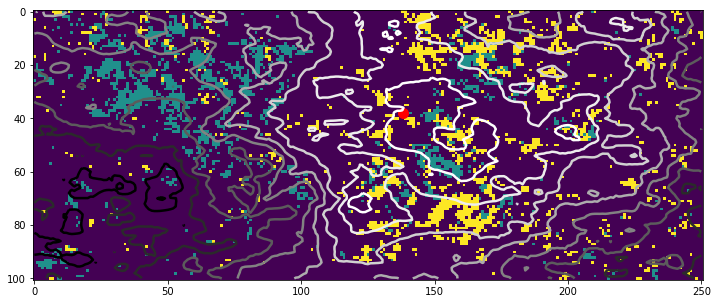

In [20]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
res_indicator = np.zeros((25351, 1))
res_indicator[np.where((np.sqrt(all_latents[:, 0]**2+all_latents[:, 1]**2)>1.5) & (all_latents[:, 0] > 0))] = 2
res_indicator[np.where((np.sqrt(all_latents[:, 0]**2+all_latents[:, 1]**2)>1.5) & (all_latents[:, 0] < 0))] = 3
res_indicator[np.where((np.sqrt(all_latents[:, 0]**2+all_latents[:, 1]**2)<1.5))] = 1
sc = ax.imshow(res_indicator.reshape(101, 251), cmap="viridis")
c1 = ax.contour(X, Y, horizon, alpha=1.0, levels=np.linspace(horizon.min(), horizon.max(), 10), linewidths=2.5, cmap="Greys")
#fig.savefig("unsupervised_labeling_of_encoder_space_with_surface.png", dpi=300, bbox_inches="tight")
ax.scatter([138], [38], s=100, color="red")

### Finally, latent space distance from origin, the well and the structural contours

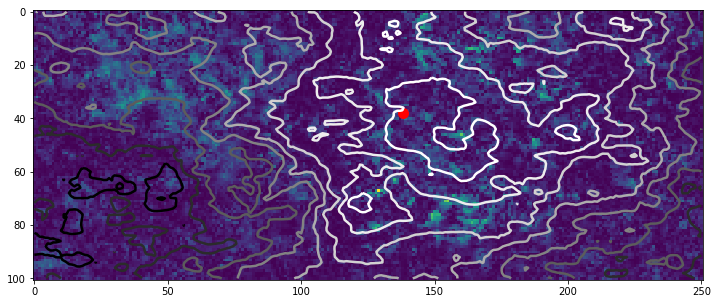

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(12, 12))
c1 = ax.contour(X, Y, horizon, alpha=1.0, levels=np.linspace(horizon.min(), horizon.max(), 10), linewidths=2.5, cmap="Greys")
ax.imshow(r.reshape(101, 251))
ax.scatter([138], [38], s=100, color="red")